# Problem 1

1. Here is least squares problem formulation of the problem
<br />
<br />
$\min_{A_{12},A_{21}}\sum_{i=1}^{11} (P(x_i,A_{12},A_{21})-p_i)^2 $

2. Below is the code to solve this using pytorch and gradient descent

estimation A12 and A21 is:  tensor([1.9584, 1.6892], requires_grad=True)
final loss is:  0.670194005896044


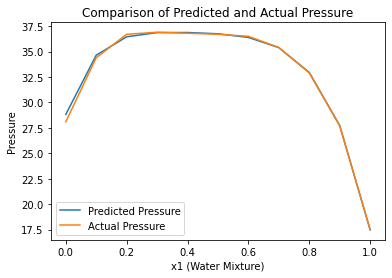

In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

T = 20
a = np.array(([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]))
pSat_w = 10**(a[0, 0]-(a[0, 1]/(T+a[0, 2])))
pSat_d = 10**(a[1, 0]-(a[1, 1]/(T+a[1, 2])))
p = np.array([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])
x1 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
x2 = 1-x1

p = torch.tensor(p, requires_grad=False, dtype=torch.float64)
x1 = torch.tensor(x1, requires_grad=False, dtype=torch.float64)
x2 = torch.tensor(x2, requires_grad=False, dtype=torch.float64)

# includes initial guess of A12 and A21
A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)

step = 0.0001
eps = 1e-3
P = x1 * torch.exp(A[0] * ((A[1]*x2)/(A[0]*x1+A[1]*x2)) ** 2) * pSat_w + x2 * torch.exp(A[1] * ((A[0]*x1)/(A[0]*x1+A[1]*x2)) ** 2) * pSat_d

loss = (P-p) ** 2
loss = loss.sum()

# computes gradient for current guess
loss.backward()

# norm of a grad
er = torch.norm(A.grad).item()
while er >= eps:
    P = x1 * torch.exp(A[0] * ((A[1] * x2) / (A[0] * x1 + A[1] * x2)) ** 2) * pSat_w + x2 * torch.exp(
        A[1] * ((A[0] * x1) / (A[0] * x1 + A[1] * x2)) ** 2) * pSat_d

    loss = (P - p) ** 2
    loss = loss.sum()

    # computes gradient for current guess
    loss.backward()

    # norm of a grad
    er = torch.norm(A.grad).item()
    # get numerical value of gradient
    with torch.no_grad():
        A -= step * A.grad

        # have to zero out the grad
        A.grad.zero_()

print('estimation A12 and A21 is: ', A)
print('final loss is: ', loss.data.numpy())

# Plotting
P = P.detach().numpy()
p = p.detach().numpy()
x1 = x1.detach().numpy()

plt.plot(x1, P, label='Predicted Pressure')
plt.plot(x1, p, label='Actual Pressure')
plt.xlabel("x1 (Water Mixture)")
plt.ylabel("Pressure")
plt.legend()
plt.title("Comparison of Predicted and Actual Pressure")
plt.show()

3. As you can see from the graph the predicted pressure lines up very closely with the actual pressure data provided. This means our model fits the data well. The loss being only 0.67 also indicates that the model fits the graph very well

# Problem 2

Below is the off-the-shelf Bayesian Optimization solver I used with the code I added at the very bottom to solve problem 2. The solver was taken from here: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py

In [4]:
""" gp.py
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp


# code to call optimization
n_iters = 500
f = lambda x: (4-2.1*x[0]**2+((x[0]**4)/3))*x[0]**2+x[0]*x[1]+(-4+4*x[1]**2)*x[1]**2
bounds = np.array([[-3, 3], [-2, 2]])
x1x2, output = bayesian_optimisation(n_iters, f, bounds, x0=None, n_pre_samples=5, gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7)
minIndex = np.argmin(output)
print("Min index: ", minIndex)
print("Min value: ", output[minIndex])
print("X1 and X2 at min: ", x1x2[minIndex])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Min index:  60
Min value:  -1.0160231913091697
X1 and X2 at min:  [-0.15310215  0.722924  ]
